In [1]:
import sys
import numpy as np
import time
from explauto.utils import rand_bounds
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
%matplotlib inline
import matplotlib.pyplot as plt

env_audio = CogSci2017Environment(audio=True)
env = CogSci2017Environment()


# Define Vowels and triplets
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
#v_a = list(np.log2([800, 1300]))

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)
                     
def check_sounds(s_traj, tol=0.25):    
    if s_traj is None:
        return "NNN"
    s1 = s_traj[0]
    s2 = s_traj[24]
    s3 = s_traj[-1]
    
    v1 = "N"
    v2 = "N"
    v3 = "N"
    
    for v in vowels.keys():
        if abs(s1[0]-vowels[v][0]) < tol and abs(s1[1]-vowels[v][1]) < tol:
            v1 = v
        if abs(s2[0]-vowels[v][0]) < tol and abs(s2[1]-vowels[v][1]) < tol:
            v2 = v
        if abs(s3[0]-vowels[v][0]) < tol and abs(s3[1]-vowels[v][1]) < tol:
            v3 = v
    
    sound = v1 + v2 + v3
    
    return sound

human sounds ['iuo', 'yeo', 'eou', 'uye', 'eyu', 'oey']
human sounds ['uye', 'iuo', 'eou', 'oey', 'eyu', 'yeo']


(array([-10.22881869]), array([-7.64385619]))

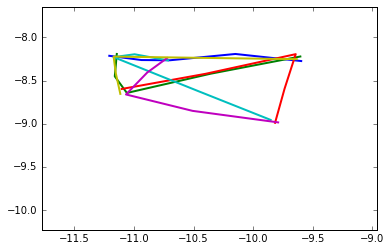

In [2]:
human_sounds = ["uyi", "ieu", "euo", "oiy", "oey", "uie"]

def compute_s_sound(sound):
    s1 = vowels[sound[0]]
    s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
    s3 = vowels[sound[1]]
    s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
    s5 = vowels[sound[2]]
    rdm = 0.05 * (2.*np.random.random((1,10))[0] - 1.)
    return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


human_sounds_traj = dict()
human_sounds_traj_std = dict()
for hs in human_sounds:
    human_sounds_traj[hs] = compute_s_sound(hs)
    human_sounds_traj_std[hs] = human_sounds_traj[hs]
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    
    plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=2)
    
plt.xlim([-np.log2([3500.]), -np.log2([500.])])
plt.ylim([-np.log2([1200.]), -np.log2([200.])])

In [4]:
from cogsci2017.learning.supervisor import Supervisor



def train(n_motor_babbling=100, n_goal_babbling=900, n_imitation_each=500, explo_noise=0.1):
    
    m_list = []
    sound_list = []
    sound_dict = {}
    vowels_dict = {}
    iteration = 0
    
    s_traj_mb_list = []
    s_traj_gb_list = []
    s_traj_im_list = []

    config = dict(m_mins=env.conf.m_mins,
                 m_maxs=env.conf.m_maxs,
                 s_mins=env.conf.s_mins,
                 s_maxs=env.conf.s_maxs)

    agent = Supervisor(config, explo_noise=explo_noise)
    

    for i in range(n_motor_babbling + n_goal_babbling):
        if i < n_motor_babbling:
            m = agent.motor_babbling(audio=True)
        else:
            context = env.get_current_context()
            m = agent.produce(context)
            
        s = env.update(m)
        agent.perceive(s)

        m_list.append(m)
        s_traj = env.diva_traj
        
        if s_traj is not None:

            sound = check_sounds(s_traj)
            sound_list.append(sound)
            if sound_dict.has_key(sound):
                sound_dict[sound] += [iteration]
            else:
                sound_dict[sound] = [iteration]
            for v in vowels:
                if v in sound:
                    if vowels_dict.has_key(v):
                        vowels_dict[v] += [iteration]
                    else:
                        vowels_dict[v] = [iteration]
            if i < n_motor_babbling:
                plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
                s_traj_mb_list.append(s_traj)
            else:
                plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="g", alpha=0.2)
                s_traj_gb_list.append(s_traj)
        iteration += 1
           
    results_errors = {}
    results_sounds = {}
    results_it = {}

    for hs in env.human_sounds:
        results_errors[hs] = []
        results_sounds[hs] = []
        results_it[hs] = -1 

    for hs in [env.human_sounds[0]]:
        #IMITATE
        #best_sound_list, error_list = train_imitation(agent, hs, iterations=n_imitation_each, explo_noise=explo_noise)
        #print agent.modules["mod13"].sm.bootstrapped_s
        m = agent.modules["mod13"].inverse(np.array(env.human_sounds_traj_std[hs]), explore=False) 
        s = env.update([0.]*21 + list(m))
        s_traj = env.diva_traj
        best_error = np.linalg.norm(np.array(env.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
        best_sound = check_sounds(s_traj)
        #print "best error", best_error
        #print "s_traj", s_traj, human_sounds_traj[hs]
        error_list = []
        best_sound_list = []

        for i in range(n_imitation_each):
            #print env.get_current_context()
            m = agent.modules["mod13"].inverse(np.array(env.human_sounds_traj_std[hs]), explore=True) 
            #print m
            agent.m = [0.]*21 + list(m)
            s = env.update(agent.m)
            agent.perceive(s)
            s_traj = env.diva_traj


            m_list.append(m)
            if s_traj is not None:
                s_traj_im_list.append(s_traj)

                sound = check_sounds(s_traj)
                sound_list.append(sound)
                if sound_dict.has_key(sound):
                    sound_dict[sound] += [iteration]
                else:
                    sound_dict[sound] = [iteration]
                for v in vowels:
                    if v in sound:
                        if vowels_dict.has_key(v):
                            vowels_dict[v] += [iteration]
                        else:
                            vowels_dict[v] = [iteration]
            # Error
            error = np.linalg.norm(np.array(env.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))

            if error < best_error:
                best_error = error
                best_sound = sound
                print "new best error", best_error
            error_list += [best_error]
            best_sound_list += [best_sound]
            iteration += 1
        

            #plt.plot(-s_traj[0][1], -s_traj[0][0], "ok", alpha=0.2)
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
        print "end best error for sound", hs, best_error

        # Human Sound
        #plt.plot(- np.array(human_sounds_traj[hs][5:])[0], -np.array(human_sounds_traj[hs][:5][0]), "ok")
        #plt.plot(- np.array(human_sounds_traj[hs][5:]), -np.array(human_sounds_traj[hs][:5]), lw=3)



        #plt.xlim([-np.log2([3500.]), -np.log2([500.])])
        #plt.ylim([-np.log2([1200.]), -np.log2([100.])])
    
        
        
        
        results_sounds[hs] += best_sound_list
        results_errors[hs] += error_list
        try:
            results_it[hs] = results_sounds[hs].index(hs)
        except ValueError:
            results_it[hs] = -1
    
    
    plt.xlim([-np.log2([3500.]), -np.log2([500.])])
    plt.ylim([-np.log2([1200.]), -np.log2([200.])])
    for v in vowels.keys():
        plt.plot(-vowels[v][1], -vowels[v][0], "o")

    print
    for key in sound_dict.keys():
        if not (key[0] == "N" or key[1] == "N" or key[2] == "N"):
            print "Sound:", key, "  Iterations: ", sound_dict[key]
    print
    for v in vowels:
        if vowels_dict.has_key(v):
            print "Vowel [", v, "] played", len(vowels_dict[v]), "times"

    def listen(i):
        print "Playing sound: ", sound_list[i], "of iteration ", i
        m = m_list[i]
        env_audio.diva.update(m[21:])

    def listen_triplets():
        for key in sound_dict.keys():
            if not (key[0] == "N" or key[1] == "N" or key[2] == "N"):
                for i in sound_dict[key]:
                    listen(i)
                    time.sleep(1)
            
                    
    return results_sounds, results_errors, results_it, s_traj_mb_list, s_traj_gb_list, s_traj_im_list, agent

In [ ]:
# FIND MOST DIVERSE SET OF SOUNDS
import itertools
def min_dist(human_sounds):
    
    
    v_o = list(np.log2([500, 900]))
    v_y = list(np.log2([300, 1700]))
    v_u = list(np.log2([300, 800]))
    v_e = list(np.log2([400, 2200]))
    v_i = list(np.log2([300, 2300]))


    vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)    

    def compute_s_sound(sound):
        s1 = vowels[sound[0]]
        s2 = [(vowels[sound[0]][0] + vowels[sound[1]][0]) / 2., (vowels[sound[0]][1] + vowels[sound[1]][1]) / 2.]
        s3 = vowels[sound[1]]
        s4 = [(vowels[sound[1]][0] + vowels[sound[2]][0]) / 2., (vowels[sound[1]][1] + vowels[sound[2]][1]) / 2.]
        s5 = vowels[sound[2]]
        rdm = 0.0 * (2.*np.random.random((1,10))[0] - 1.)
        return list(rdm + np.array([f[0] for f in [s1, s2, s3, s4, s5]] + [f[1] for f in [s1, s2, s3, s4, s5]]))


    human_sounds_traj = dict()
    for hs in human_sounds:
        human_sounds_traj[hs] = compute_s_sound(hs)
            
    min_d = 2.
    for ihs1 in range(6):
        for ihs2 in range(ihs1+1, 6):
            hs1 = human_sounds[ihs1]
            hs2 = human_sounds[ihs2]
            d = np.linalg.norm(np.array(human_sounds_traj[hs1]) - 
                               np.array(human_sounds_traj[hs2]))
            #print hs1, hs2, d
            if d < min_d:
                min_d = d
    return min_d


sounds = ["oie", "oei", "oey", "oye", "oiy", "oyi", "uie", "uei", "uey", "uye", "uiy", "uyi", 
    "ieo", "ieu", "iyo", "iyu", "iou", "iuo",
    "eio", "eiu", "eyo", "eyu", "eou", "euo", 
    "yio", "yiu", "yeo", "yeu", "you", "yuo"]

max_min_d = 0.
best_sounds = []

it = itertools.combinations(sounds, 6)

try:
    while True:
        hs = list(next(it))
        min_d = min_dist(hs)
        if min_d > max_min_d:
            max_min_d = min_d
            best_sounds = hs
except:
    print max_min_d
    print best_sounds
    
#1.26428500985
#['oey', 'uye', 'iuo', 'eyu', 'eou', 'yeo']


../cogsci2017/environment/diva/diva.py:169: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


True
[ 0.82630977 -0.35426    -0.42273543  0.8374986  -0.46976177 -0.12426788
  0.36650726 -0.30912074 -0.59800311  0.29873786 -0.01917852  0.68067914
  0.19589321  0.71371956  0.2783169   0.66588345 -1.          0.72086297
  0.17286495 -0.18984647  0.65176322  0.91894351  0.82277523 -0.54777688
 -0.37123562 -0.24837249  0.75916961  0.69845203]
[ 0.95139221  0.11242503 -0.35543681  1.         -0.48927657 -0.23228902
  0.17490671 -0.3164419  -0.60193925  0.4870423   0.13836123  0.51921298
  0.1199571   0.80085152  0.42260383  0.70080758 -0.86523072  0.54217224
  0.09461898 -0.24808078  0.65070842  0.75459085  0.72947273 -0.58592582
 -0.32420403  0.03233559  0.95157487  0.43624179]
[ 0.91036362 -0.24222188 -0.58067644  0.99089333 -0.50408534 -0.12085803
  0.33660045 -0.42947003 -0.46799694  0.48519681 -0.16062016  0.55860894
  0.1671328   0.70016944  0.46891093  0.72289672 -0.87084331  0.59333921
  0.06484515 -0.23223019  0.75897973  0.68458309  0.96551617 -0.351006
 -0.45681027  0.00540

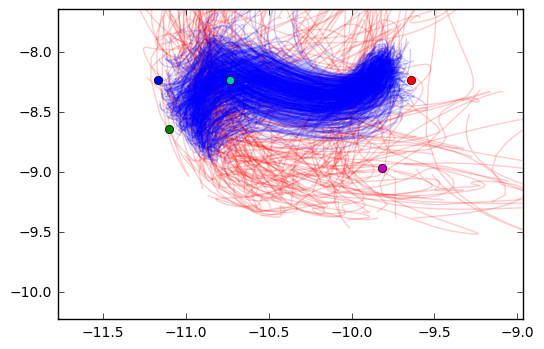

In [3]:
_, _, _, s_traj_mb_list, s_traj_gb_list, s_traj_im_list, agent = train(n_motor_babbling=200, n_goal_babbling=0, n_imitation_each=500, explo_noise=0.05)

0.27952091156


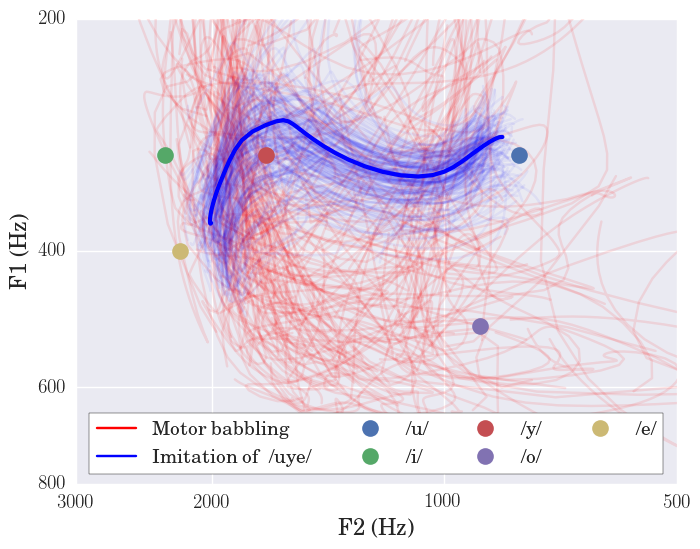

In [30]:
%matplotlib inline
import seaborn as sns
import numpy as np


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for s_traj in s_traj_mb_list[:200]:
    if np.all(s_traj):
        plt.loglog([2.**f[1] for f in s_traj], [2.**f[0] for f in s_traj], color="r", alpha=0.1)
plt.loglog([2.**f[1] for f in s_traj_mb_list[0]], [2.**f[0] for f in s_traj_mb_list[0]], color="r", alpha=0., label="Motor babbling")

hs = "uye"


for s_traj in s_traj_im_list[-200:]:
    error = np.linalg.norm(np.array(env.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
    if np.all(s_traj):
        if error < 0.28:
            print error
            plt.loglog([2.**f[1] for f in s_traj], [2.**f[0] for f in s_traj], lw=3,color="b", alpha=1.)
        else:
            plt.loglog([2.**f[1] for f in s_traj], [2.**f[0] for f in s_traj], color="b", alpha=0.05)
plt.loglog([2.**f[1] for f in s_traj_im_list[0]], [2.**f[0] for f in s_traj_im_list[0]], color="b", alpha=0., label="Imitation of~ /uye/")

plt.xlim([3000., 500])
plt.ylim([800., 200.])
    
for v in ["u", "i", "y", "o", "e"]:
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)
    #color = p[0].get_color()
    #plt.plot(vowels[v][1], vowels[v][0], "o", color=color, markeredgecolor=color, markersize=30, markeredgewidth=1, markerfacecolor='None')
    
plt.gcf().set_size_inches(8., 6., forward=True)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")
plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)

plt.xticks([3000., 2000., 1000., 500.], 
           ["$3000$", "$2000$", "$1000$", "$500$"], fontsize = 14)
plt.yticks([800., 600., 400., 200.], 
           ["$800$", "$600$", "$400$", "$200$"], fontsize = 14)

frame = legend.get_frame()
frame.set_facecolor('1.')
frame.set_edgecolor('0.')

for l in legend.get_lines():
    l.set_alpha(1)
    
plt.gca().set_aspect('equal')

plt.savefig('../figs/fig_vocal_traj.pdf', format='pdf', bbox_inches='tight')

In [7]:
env.human_sounds

['uye', 'iuo', 'eou', 'oey', 'yeo', 'eyu']